In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import xgboost as xgb
import catboost as cat
import matplotlib.pyplot as plt
from typing import Tuple, Callable
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, classification_report
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.svm import SVC
from category_encoders.one_hot import OneHotEncoder
from sklearn.calibration import CalibratedClassifierCV
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import precision_recall_curve
from sklearn.ensemble import RandomForestClassifier

In [2]:
np.random.seed(42)

In [3]:
DATA_PATH = '.\\data'
DATASET_PATH = os.path.join(DATA_PATH, 'WA_Fn-UseC_-Telco-Customer-Churn.csv')

### Support variables

#### Features

In [4]:
GENDER = 'gender'
SENIOR_CITIZEN = 'SeniorCitizen'
PARTNER = 'Partner'
DEPENDENTS = 'Dependents'
PHONE_SERVICE = 'PhoneService'
MULTIPLE_LINES = 'MultipleLines'
INTERNET_SERVICE = 'InternetService'
ONLINE_SECURITY = 'OnlineSecurity'
ONLINE_BACKUP = 'OnlineBackup'
DEVICE_PROTECTION = 'DeviceProtection'
TECH_SUPPORT = 'TechSupport'
STREAMING_TV = 'StreamingTV'
STREAMING_MOVIES = 'StreamingMovies'
CONTRACT = 'Contract'
PAPERLESS_BILLING = 'PaperlessBilling'
PAYMENT_METHOD = 'PaymentMethod'
CHURN = 'Churn'

### Support data

In [5]:
DEFAULT_OTHER_NAME = 'Other'
DEFAULT_NAN_NAME = 'NaN'
DEFAULT_OTHER_FOR_NUMERIC = -99999
DEFAULT_NAN_FOR_NUMERIC = -88888
THRESHOLD_FRAC = 0.005

In [6]:
CAT_FEATURES = [GENDER, SENIOR_CITIZEN, PARTNER, DEPENDENTS, PHONE_SERVICE, MULTIPLE_LINES,
                INTERNET_SERVICE, ONLINE_SECURITY, ONLINE_BACKUP, DEVICE_PROTECTION, TECH_SUPPORT,
                STREAMING_TV, STREAMING_MOVIES, CONTRACT, PAPERLESS_BILLING, PAYMENT_METHOD]
FEATURES_TO_ENCODE = CAT_FEATURES.copy()
FEATURES_TO_ENCODE.remove(SENIOR_CITIZEN)

### Functions

In [7]:
def cat_features_preprocessing(train_df: pd.DataFrame, cat_feature_name: str, is_numeric: bool,
                               cat_counts_threshold: int = None, fillna: bool = True) -> Tuple[Callable]:
    """Train dataframe categorical feature preprocessing
    Parameters
    ----------
    train_df: pd.DataFrame
        Training data(pd.DataFrame)
    cat_feature_name: str
        Preprocessing feature name
    is_numeric: bool
        Set True if feature is numeric else set to False
    fillna: bool
        Fill nan by default velues according to feature type (is_numeric)
    Returns
    -------
        label_encoder: Callable 
            LabelEncoder for this type of feature
    """
    
    # Replace nan
    if fillna:
        NAN = DEFAULT_NAN_FOR_NUMERIC if is_numeric else DEFAULT_NAN_NAME
        train_df[cat_feature_name].fillna(value=NAN, inplace=True)

        # Encode by 'Other'
    if cat_counts_threshold is not None:
        train_df.loc[train_df[train_df.groupby(cat_feature_name)[cat_feature_name]
                                  .transform('size') < cat_counts_threshold][
                         cat_feature_name].index, cat_feature_name] = DEFAULT_OTHER_FOR_NUMERIC if is_numeric else DEFAULT_OTHER_NAME

    # Encode features
    label_encoder = LabelEncoder().fit(np.sort(train_df[cat_feature_name].unique()))
    train_df[cat_feature_name] = train_df[cat_feature_name].map(
        dict(zip(train_df[cat_feature_name].unique(), label_encoder.transform(train_df[cat_feature_name].unique()))))

    return label_encoder


def train_preprocessing(train_df: pd.DataFrame, threshold_dict: dict = None) -> Tuple[Callable]:
    gender_encoder = cat_features_preprocessing(train_df, cat_feature_name=GENDER, is_numeric=False)
    partner_encoder = cat_features_preprocessing(train_df, cat_feature_name=PARTNER, is_numeric=False)
    dependents_encoder = cat_features_preprocessing(train_df, cat_feature_name=DEPENDENTS, is_numeric=False)
    phone_service_encoder = cat_features_preprocessing(train_df, cat_feature_name=PHONE_SERVICE, is_numeric=False)
    multiple_lines_encoder = cat_features_preprocessing(train_df, cat_feature_name=MULTIPLE_LINES, is_numeric=False)
    internet_service_encoder = cat_features_preprocessing(train_df, cat_feature_name=INTERNET_SERVICE, is_numeric=False)
    online_security_encoder = cat_features_preprocessing(train_df, cat_feature_name=ONLINE_SECURITY, is_numeric=False)
    online_backup_encoder = cat_features_preprocessing(train_df, cat_feature_name=ONLINE_BACKUP, is_numeric=False)
    device_protection_encoder = cat_features_preprocessing(train_df, cat_feature_name=DEVICE_PROTECTION, is_numeric=False)
    tech_support_encoder = cat_features_preprocessing(train_df, cat_feature_name=TECH_SUPPORT, is_numeric=False)
    streaming_tv_encoder = cat_features_preprocessing(train_df, cat_feature_name=STREAMING_TV, is_numeric=False)
    streaming_movies_encoder = cat_features_preprocessing(train_df, cat_feature_name=STREAMING_MOVIES, is_numeric=False)
    contract_encoder = cat_features_preprocessing(train_df, cat_feature_name=CONTRACT, is_numeric=False)
    paperless_billing_encoder = cat_features_preprocessing(train_df, cat_feature_name=PAPERLESS_BILLING, is_numeric=False)
    payment_method_encoder = cat_features_preprocessing(train_df, cat_feature_name=PAYMENT_METHOD, is_numeric=False)
    churn_encoder = cat_features_preprocessing(train_df, cat_feature_name=CHURN, is_numeric=False)
    return gender_encoder, partner_encoder, dependents_encoder, phone_service_encoder, multiple_lines_encoder, \
           internet_service_encoder, online_security_encoder, online_backup_encoder, device_protection_encoder, \
           tech_support_encoder, streaming_tv_encoder, streaming_movies_encoder, contract_encoder, paperless_billing_encoder, \
           payment_method_encoder
    

def test_preprocessing(test_df: pd.DataFrame, encoders: tuple) -> None:
    for feature, encoder in zip(FEATURES_TO_ENCODE, encoders):
        NAN = DEFAULT_NAN_NAME if test_df[feature].dtype == 'O' else DEFAULT_NAN_FOR_NUMERIC
        test_df[feature].fillna(NAN, inplace=True)
        test_df[feature].loc[~test_df[feature].isin(encoder.classes_)] = DEFAULT_OTHER_NAME if test_df[feature].dtype == 'O' else DEFAULT_OTHER_FOR_NUMERIC

        # Unknown category encoding
        unknown = encoder.classes_.shape[0]
        label_encoder_dict = dict(zip(encoder.classes_, encoder.transform(encoder.classes_)))
        test_df[feature] = test_df[feature].apply(lambda x: label_encoder_dict.get(x, unknown))

### Read dataset

In [8]:
df = pd.read_csv(DATASET_PATH)

In [9]:
df.info(verbose=1)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


### EDA

#### TotalCharges preprocessing

In [10]:
df.TotalCharges.replace(to_replace=[' ', ''], value=np.nan, inplace=True)
df.TotalCharges = df.TotalCharges.astype(float)
df.TotalCharges.fillna(value=0, inplace=True)

<AxesSubplot:xlabel='Churn', ylabel='Count'>

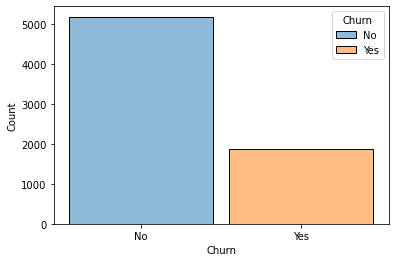

In [11]:
sns.histplot(data=df, x='Churn', hue='Churn', shrink=0.9)

In [12]:
churn_tenure = df.groupby([CHURN, 'tenure']).agg('count')['customerID'].to_frame().reset_index()

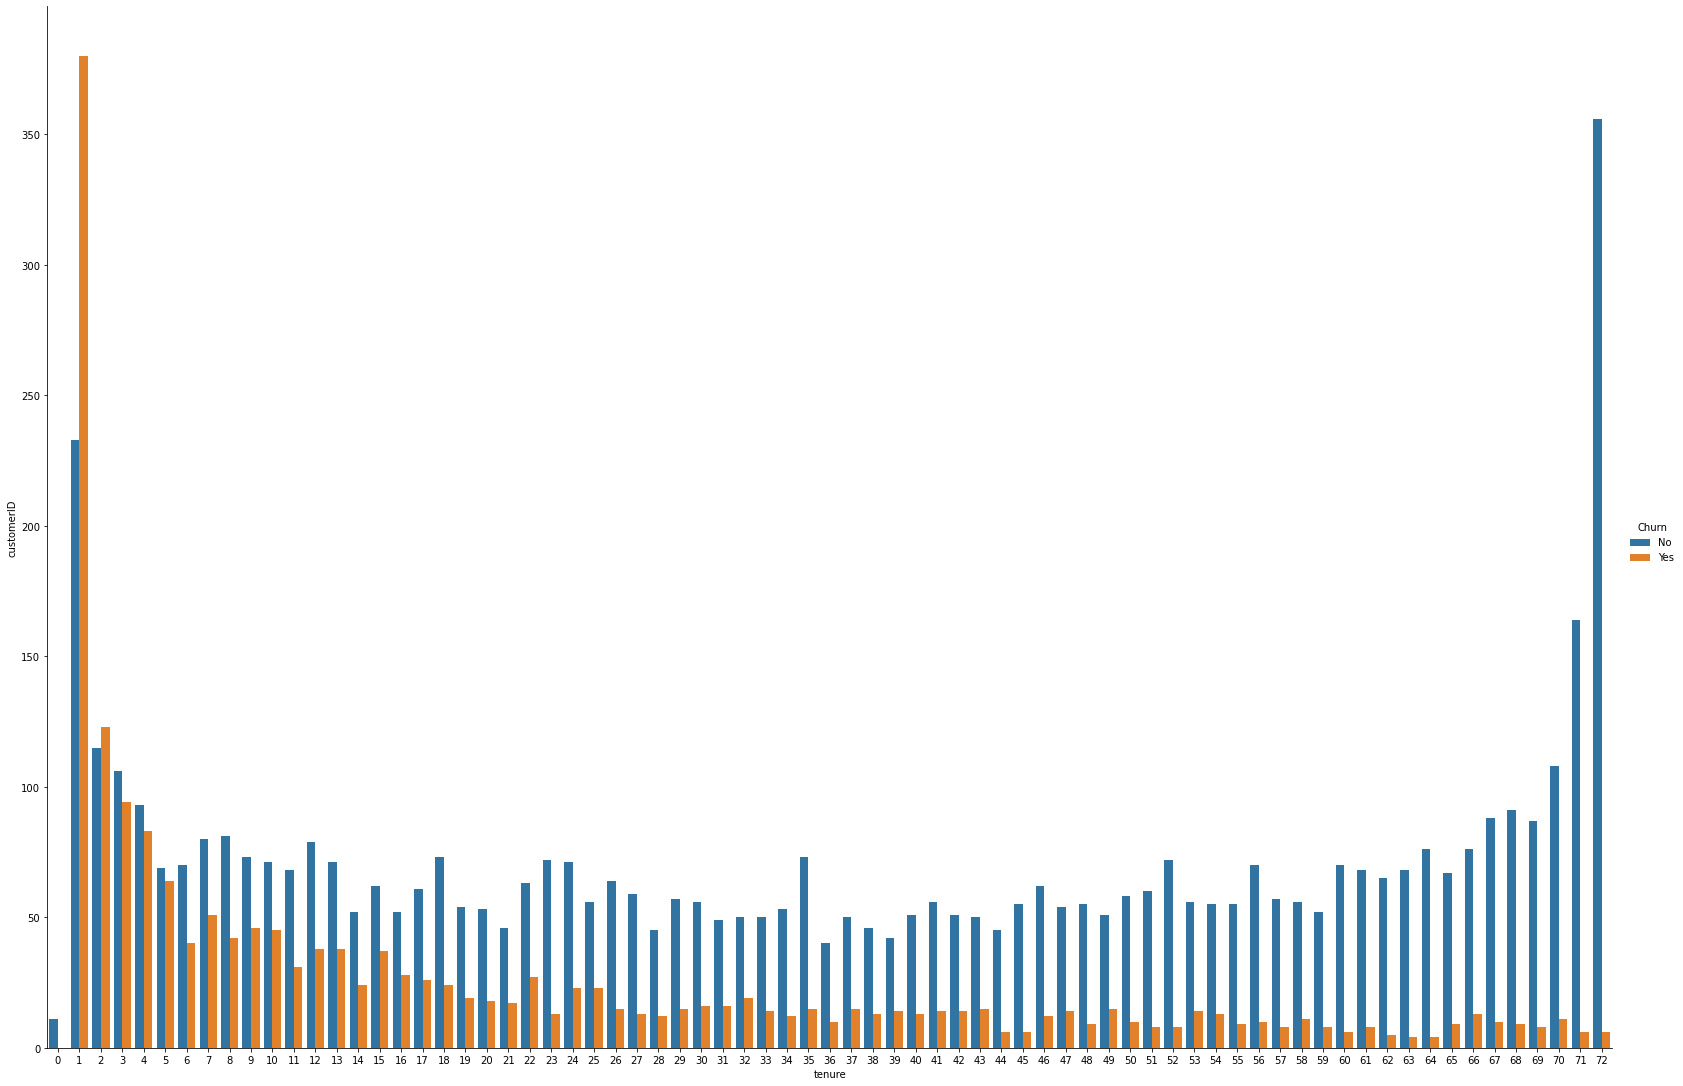

In [13]:
sns.catplot(x="tenure", y="customerID",
            hue="Churn",
            data=churn_tenure, kind="bar",
            height=15, aspect=1.5)

In [54]:
churn_monthly_charges = df.groupby([CHURN, 'tenure']).agg('mean').reset_index()

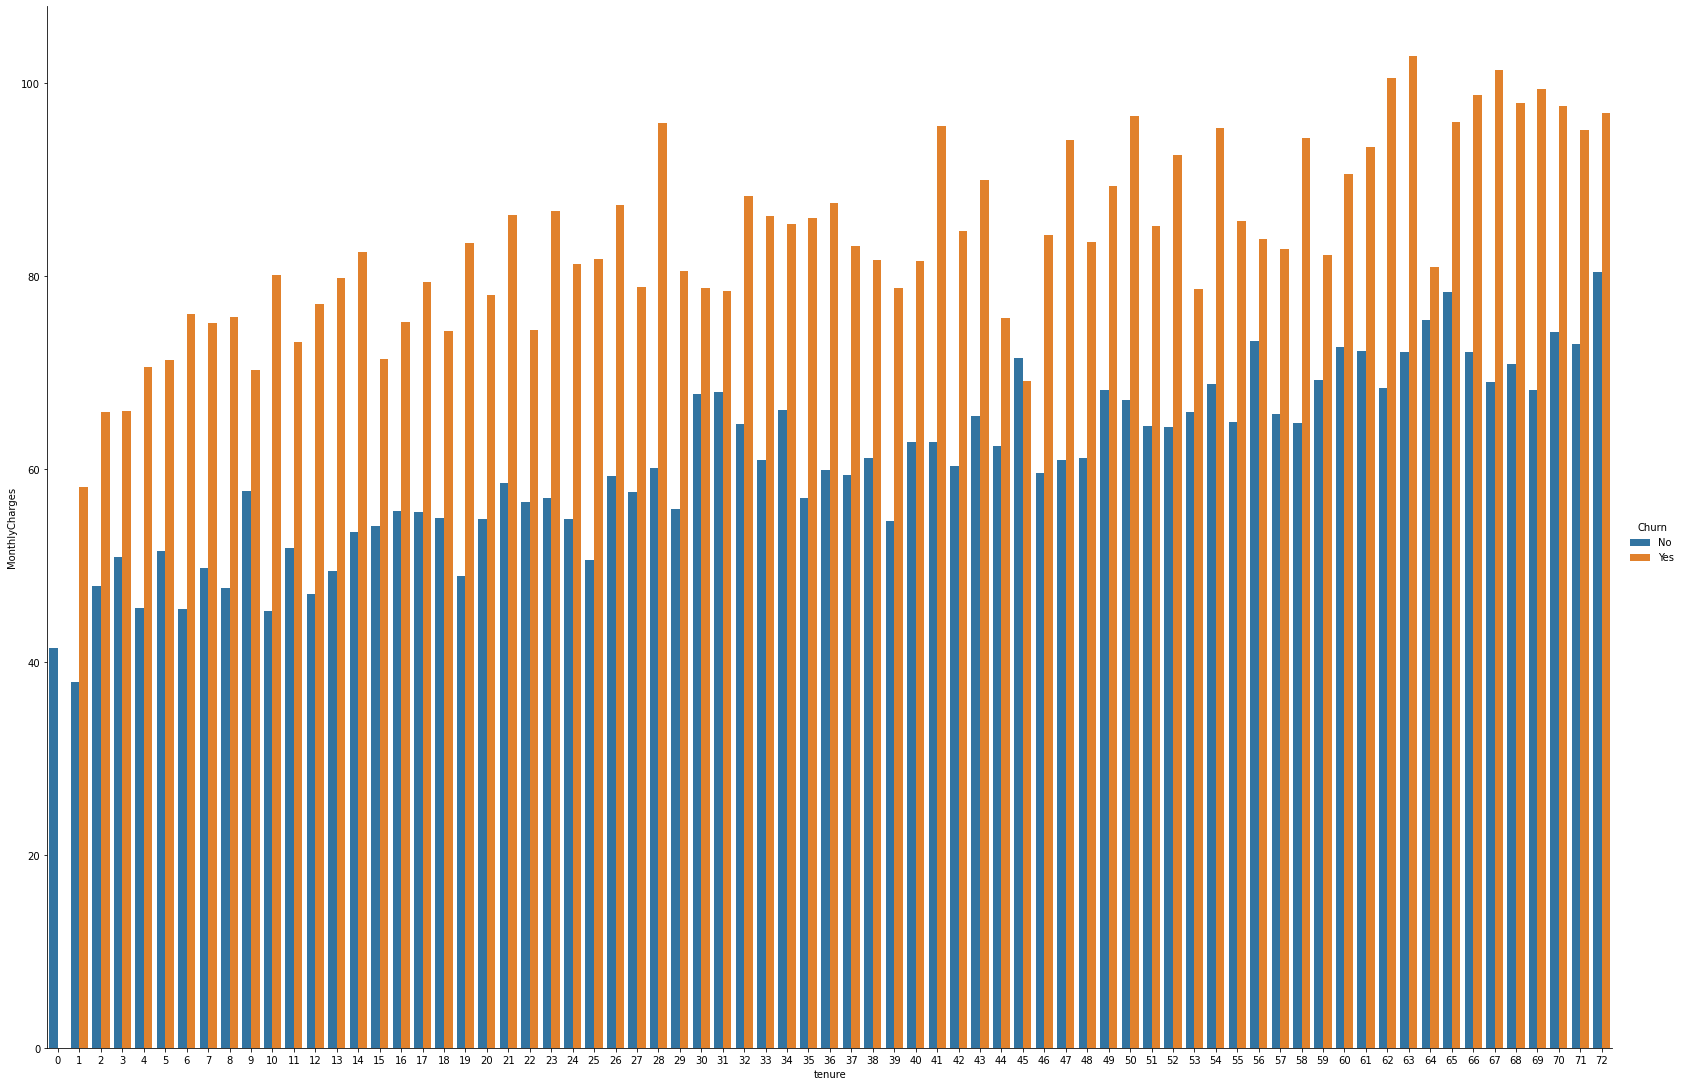

In [52]:
sns.catplot(x="tenure", y="MonthlyCharges",
            hue="Churn", data=churn_tenure, kind="bar",
            height=15, aspect=1.5)

In [14]:
x_train = df.copy()

In [15]:
encoders = train_preprocessing(x_train)

In [16]:
x_train.drop(columns=['customerID'], inplace=True)

In [17]:
x_val = x_train.sample(frac=0.1)
x_train.drop(x_val.index, inplace=True)
y_val = x_val.pop(CHURN)

x_test = x_train.sample(frac=0.2)
x_train.drop(x_test.index, inplace=True)
y_test = x_test.pop(CHURN)

y_train = x_train.pop(CHURN)

### Train

In [18]:
cat_params = {
    'random_seed': 42,
    'iterations': 500,
    'depth': 6,
    'learning_rate': 0.09,
    'l2_leaf_reg': 1,
    'scale_pos_weight': 5.8,
    'bagging_temperature': 5,
    'loss_function': 'Logloss',
    'eval_metric': 'Recall',
    'early_stopping_rounds': 60
}

In [19]:
cat_estimator = cat.CatBoostClassifier(**cat_params)

eval_set = cat.Pool(x_val, y_val, cat_features=CAT_FEATURES)
cat_estimator.fit(x_train,
                  y_train,
                  eval_set=eval_set,
                  cat_features=CAT_FEATURES,
                  verbose=20)

0:	learn: 0.9255398	test: 0.9381443	best: 0.9381443 (0)	total: 246ms	remaining: 2m 2s
20:	learn: 0.9329859	test: 0.9484536	best: 0.9484536 (19)	total: 1.45s	remaining: 33.1s
40:	learn: 0.9374535	test: 0.9432990	best: 0.9484536 (19)	total: 2.6s	remaining: 29.1s
60:	learn: 0.9374535	test: 0.9278351	best: 0.9484536 (19)	total: 3.71s	remaining: 26.7s
Stopped by overfitting detector  (60 iterations wait)

bestTest = 0.9484536082
bestIteration = 19

Shrink model to first 20 iterations.


In [20]:
cat_pred = cat_estimator.predict(x_test)

In [21]:
roc_auc_score(y_test, cat_pred)

0.7360467511069921

In [22]:
confusion_matrix(y_test, cat_pred)

array([[518, 418],
       [ 27, 305]], dtype=int64)

In [23]:
print(classification_report(y_test, cat_pred, digits=4))

              precision    recall  f1-score   support

           0     0.9505    0.5534    0.6995       936
           1     0.4219    0.9187    0.5782       332

    accuracy                         0.6491      1268
   macro avg     0.6862    0.7360    0.6389      1268
weighted avg     0.8121    0.6491    0.6678      1268



### XGBoost

In [24]:
xgb_params = {
    'learning_rate': 1,
    'max_depth': 11,
    'min_child_weight': 10,
    'n_estimators': 1,
    'num_parallel_tree': 12,
    'reg_alpha': 0,
    'reg_lambda': 2,
    'subsample': 0.9,
    'colsample_bytree': 0.95,
    'seed': 42,
    'scale_pos_weight': 17
}

In [25]:
xgb_estimator = xgb.XGBClassifier(**xgb_params)
xgb_estimator.fit(x_train, y_train, eval_set=[(x_train, y_train), (x_val, y_val)], early_stopping_rounds=50, verbose=False)

C:\Users\Timofey\anaconda3\envs\py38_base\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:25:20] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.95, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=1, max_delta_step=0, max_depth=11,
              min_child_weight=10, missing=nan, monotone_constraints='()',
              n_estimators=1, n_jobs=16, num_parallel_tree=12, random_state=42,
              reg_alpha=0, reg_lambda=2, scale_pos_weight=17, seed=42,
              subsample=0.9, tree_method='exact', validate_parameters=1,
              verbosity=None)

In [26]:
xgb_pred = xgb_estimator.predict(x_test)

In [27]:
roc_auc_score(y_test, xgb_pred)

0.7235222943054268

In [28]:
confusion_matrix(y_test, xgb_pred)

array([[472, 464],
       [ 19, 313]], dtype=int64)

In [29]:
print(classification_report(y_test, xgb_pred, digits=4))

              precision    recall  f1-score   support

           0     0.9613    0.5043    0.6615       936
           1     0.4028    0.9428    0.5645       332

    accuracy                         0.6191      1268
   macro avg     0.6821    0.7235    0.6130      1268
weighted avg     0.8151    0.6191    0.6361      1268

